In [1]:
from appgeopy import *
from my_packages import *

In [2]:
# Load data from Excel
filepath = r"TSX_Sen1A_VERT_scatterplot_100m.xz"
df = pd.read_pickle(filepath)
# df = df.iloc[::].reset_index(drop=True)
df.shape

(5548421, 4)

In [3]:
df_groupbyS1A = df.groupby("S1A_PointKey").mean().reset_index(drop=False)
df_groupbyS1A.head(5)

,S1A_PointKey,S1A_phdisp,TSX_phdisp
0,X172027Y2606814,15.576419,10.315320
1,X172038Y2606855,17.554164,10.315320
2,X172048Y2606825,12.412079,11.684211
3,X172069Y2606878,13.575011,11.684211
4,X172132Y2607221,18.927239,16.148352


In [47]:
from scipy.interpolate import interpn
from matplotlib.cm import ScalarMappable
from matplotlib.ticker import MaxNLocator

# Create a density scatter plot
def density_scatter(x, y, ax=None, sort=True, bins=20, **kwargs):
    if ax is None:
        fig, ax = plt.subplots()

    # 2D histogram to calculate density
    data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=False)

    # Interpolate density values for the scatter points
    z = interpn((0.5 * (x_e[1:] + x_e[:-1]), 0.5 * (y_e[1:] + y_e[:-1])), data, np.vstack([x, y]).T, method="splinef2d", bounds_error=False)

    # Handle NaN values (set them to zero)
    z[np.isnan(z)] = 0.0

    # Sort points by density (densest plotted last for visibility)
    if sort:
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    # Create scatter plot, color-coded by density
    scatter = ax.scatter(x, y, c=z, cmap="turbo", s=200, edgecolor='none', linewidths=0.75)

    # Add color bar
    norm = Normalize(vmin=np.min(z), vmax=np.max(z))
    cbar = ax.get_figure().colorbar(ScalarMappable(norm=norm, cmap="turbo"), ax=ax, shrink=0.4, pad=0.01)
    cbar.ax.set_ylabel("Points / Unit Area", fontsize=16)
    cbar.ax.tick_params(labelsize=14)
    # Or use MaxNLocator to automatically set tick intervals
    cbar.ax.yaxis.set_major_locator(MaxNLocator(integer=True, prune='lower'))  # Adjusts tick intervals
    return ax


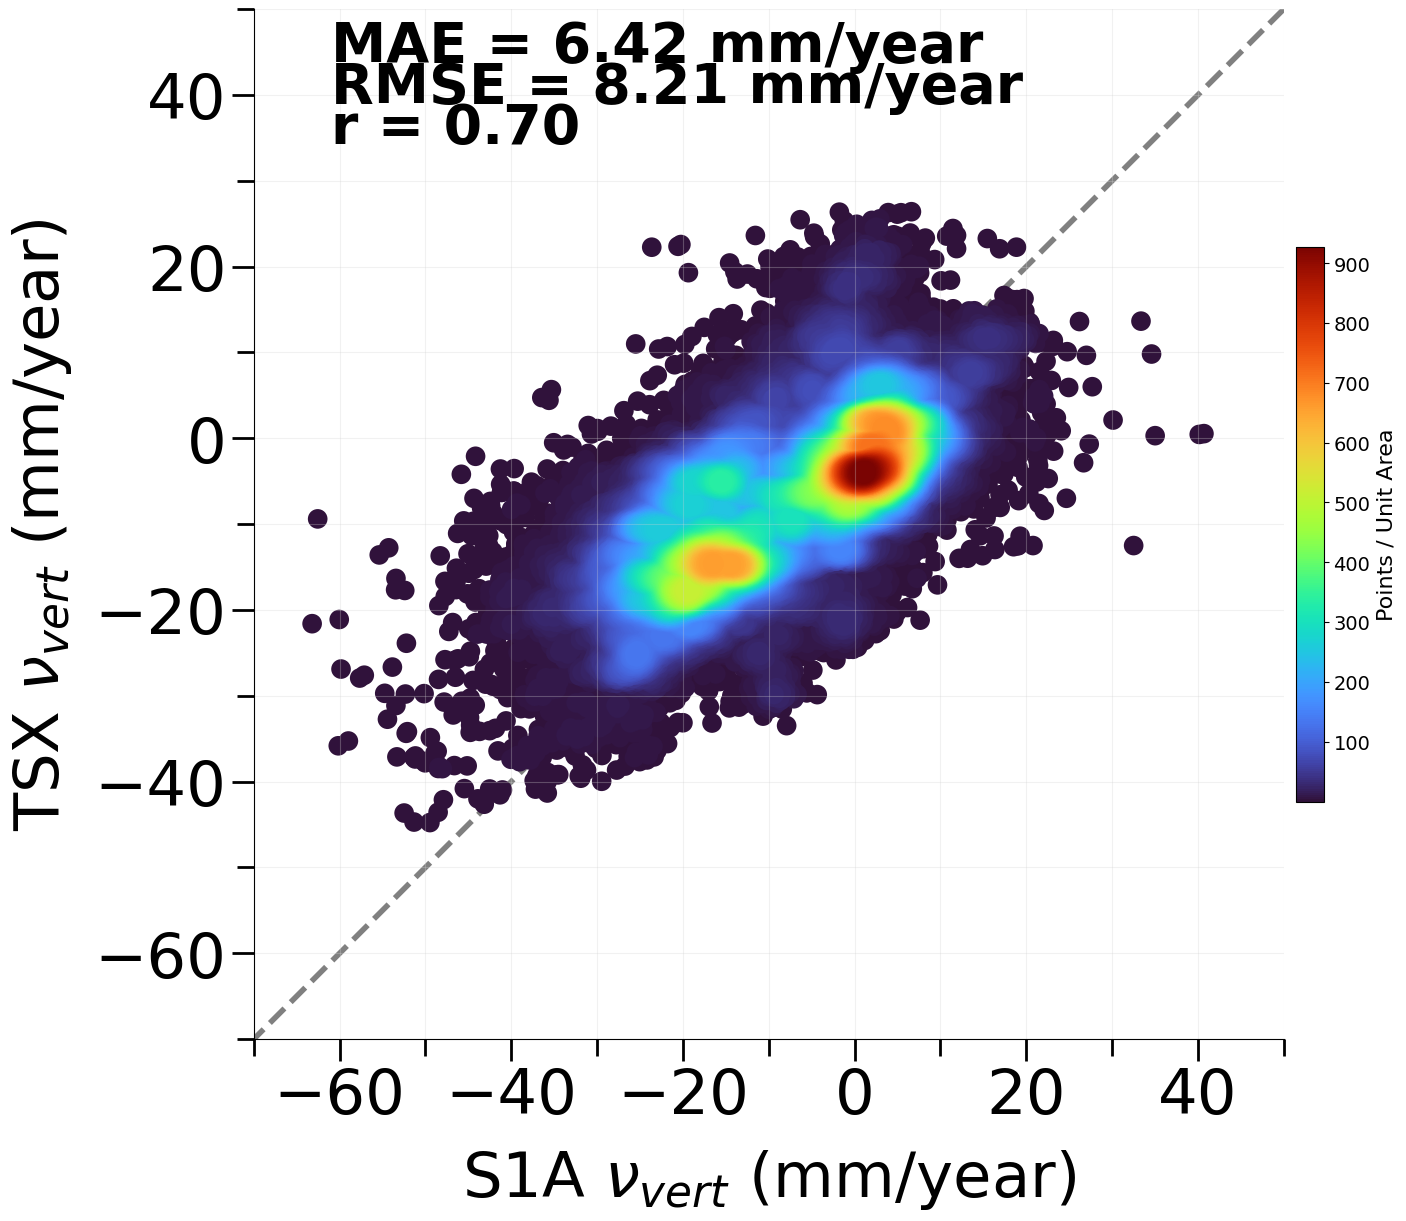

In [59]:
# Set the base name for saving figures
base = "TSX_surround_S1A_compare"
figSave = False
folder2savefigure = os.getcwd()

cm = 1 / 2.54

multiplier = 1.5

df = df_groupbyS1A.copy()

fig = plt.figure(figsize=(10 * multiplier, 10 * multiplier))
ax = fig.add_subplot(1, 1, 1)

ax.grid(axis="both", which="both", color="lightgrey", alpha=0.3)
top_thres = 50
bot_thres = -70

x1, y1 = [top_thres, bot_thres], [top_thres, bot_thres]
ax.plot(x1, y1, linestyle="--", color="gray", linewidth=4, zorder=1)

ax.set_xlim(bot_thres, top_thres)
ax.set_ylim(bot_thres, top_thres)

ax.set_aspect(aspect="equal", adjustable="box")

x_axis_object = "S1A_phdisp"
y_axis_object = "TSX_phdisp"
x_axis_label = r"S1A ${\nu}_{vert}$ (mm/year)"
y_axis_label = r"TSX ${\nu}_{vert}$ (mm/year)"

scatter_points = [(psc, lev) for psc, lev in zip(df[x_axis_object], df[y_axis_object])]

# scatter_plot = ax.scatter(*zip(*scatter_points), s=200, facecolors="none", edgecolors="None", marker="o")

x = df[x_axis_object]
y = df[y_axis_object]

# Call the density scatter plot function
density_scatter(x, y, ax=ax, bins=50)

ax.set_xlabel(x_axis_label, fontsize=45, labelpad=15)
ax.set_ylabel(y_axis_label, fontsize=45, labelpad=15)

mean_abs_err = np.mean(np.abs(x - y))
rmse = np.sqrt(np.mean((x - y) ** 2))
m, c, r, p, se1 = stats.linregress(x, y)

major_base = 20
minor_base = 10

x_major_loc = plticker.MultipleLocator(base=major_base)
x_minor_loc = plticker.MultipleLocator(base=minor_base)
ax.xaxis.set_major_locator(x_major_loc)
ax.xaxis.set_minor_locator(x_minor_loc)

y_major_loc = plticker.MultipleLocator(base=major_base)
y_minor_loc = plticker.MultipleLocator(base=minor_base)
ax.yaxis.set_major_locator(y_major_loc)
ax.yaxis.set_minor_locator(y_minor_loc)

ax.tick_params(axis="y", which="major", labelsize=45, direction="out", length=16, width=2)
ax.tick_params(axis="y", which="minor", labelsize=45, direction="out", length=12, width=2)

ax.tick_params(axis="x", which="major", labelsize=45, direction="out", length=16, width=2)
ax.tick_params(axis="x", which="minor", labelsize=45, direction="out", length=12, width=2)

ax.text(
    0.075,
    0.95,
    f"MAE = {mean_abs_err:.2f} mm/year",
    transform=plt.gca().transAxes,
    fontweight="bold",
    fontsize=40,
)
ax.text(
    0.075,
    0.91,
    f"RMSE = {rmse:.2f} mm/year",
    transform=plt.gca().transAxes,
    fontweight="bold",
    fontsize=40,
)

ax.text(
    0.075,
    0.87,
    f"r = {r:.2f}",
    transform=plt.gca().transAxes,
    fontweight="bold",
    fontsize=40,
)

ax.spines[["right", "top"]].set_visible(False)

fig.tight_layout()


for i in range(1, 1001):
    savename = os.path.join(folder2savefigure, base + "_{}.png".format(str(i).zfill(3)))
    if os.path.exists(savename):
        continue
    else:
        break

if figSave:
    plt.savefig(
        savename,
        dpi=600,
        transparent=False,
        facecolor="w",
        edgecolor="w",
        bbox_inches="tight",
    )
# plt.close()
plt.show()

In [46]:
np.max(x), np.min(x)

(40.6945235741, -63.2044881659)

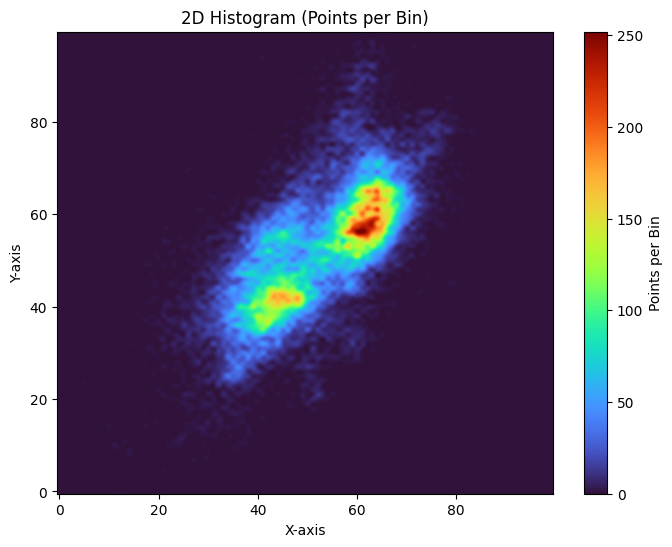

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
# np.random.seed(0)
# n_points = 1000  # Number of data points
# x = np.random.randn(n_points)  # Random data points for x (normally distributed)
# y = np.random.randn(n_points)  # Random data points for y (normally distributed)

x = df[x_axis_object]
y = df[y_axis_object]

# Parameters for the histogram
bins = 100  # Number of bins for each axis (you can change this value)

# Create a 2D histogram to calculate the density
data, x_e, y_e = np.histogram2d(x, y, bins=bins, density=False)  # No density scaling, just count

# Create a figure and axis for plotting
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the 2D histogram as a heatmap
cax = ax.imshow(data.T, origin='lower', interpolation='spline36', cmap='turbo', aspect='auto')

# Set labels and title
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_title('2D Histogram (Points per Bin)')

# Add a color bar
fig.colorbar(cax, label='Points per Bin')

# Show the plot
plt.show()
